In [2]:
import pandas as pd
import numpy as np
import nibabel as nib
import brainstat as bs
import hippomaps as hm
from brainstat.stats.terms import FixedEffect
from brainstat.stats.SLM import SLM
import brainspace
import pingouin as pg
import statsmodels.api as sm
import seaborn as sb
import statistics
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from scipy.stats import pearsonr

In [4]:
# --- Volumetric analyses: Anterior/Posterior volumes ~ behaviors (L & R) ----
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import numpy as np

comp_antpost_L_synthseg = pd.read_csv('/Users/nimatalaeikamalabadi/Project1/Final_data/GitHubData/comp_antpost_93_L_synthseg_github.csv')
comp_antpost_R_synthseg = pd.read_csv('/Users/nimatalaeikamalabadi/Project1/Final_data/GitHubData/comp_antpost_93_R_synthseg_github.csv')

subfields  = ['Total_Anterior_Volume', 'Total_Posterior_Volume']
behaviors  = ['InternalTotal', 'ExternalTotal', 'Scene', 'Future', 'Navigation']

def run_hemi(df: pd.DataFrame, hemi_label: str) -> pd.DataFrame:
    rows = []
    for beh in behaviors:
        for sub in subfields:
            res = smf.ols(
                formula=f'{beh} ~ {sub} + Age + C(Sex1M2F) + C(Scanner) + IntracranialVolume',
                data=df
            ).fit()
            t  = float(res.tvalues[sub])
            p  = float(res.pvalues[sub])
            df_resid = float(res.df_resid)
            r  = t / np.sqrt(t**2 + df_resid)  # point-biserial-style effect from t & df
            rows.append({"hemi": hemi_label, "behavior": beh, "subfield": sub,
                         "t": t, "p": p, "df_resid": df_resid, "r": r})
    out = pd.DataFrame(rows)
    out["p_fdr"] = sm.stats.multipletests(out["p"].values, alpha=0.05, method="fdr_bh")[1]
    out["sig_fdr"] = out["p_fdr"] < 0.05
    return out

# Run both hemispheres 
results_L = run_hemi(comp_antpost_L_synthseg, "L")
results_R = run_hemi(comp_antpost_R_synthseg, "R")

# Print concise summaries
def print_summary(df, hemi_label):
    print(f"\n=== {hemi_label} hemisphere: FDR-corrected results ===")
    disp = df.sort_values(["p_fdr", "p"]).loc[:, ["behavior","subfield","t","r","p","p_fdr","sig_fdr"]]
    print(disp.to_string(index=False))

print_summary(results_L, "Left")
print_summary(results_R, "Right")


=== Left hemisphere: FDR-corrected results ===
     behavior               subfield         t         r        p    p_fdr  sig_fdr
ExternalTotal Total_Posterior_Volume  1.936874  0.204447 0.056044 0.560439    False
ExternalTotal  Total_Anterior_Volume  1.357122  0.144800 0.178294 0.891469    False
        Scene Total_Posterior_Volume  0.902293  0.096840 0.369421 0.962598    False
       Future  Total_Anterior_Volume -0.310903 -0.033507 0.756627 0.962598    False
InternalTotal  Total_Anterior_Volume -0.295723 -0.031872 0.768155 0.962598    False
       Future Total_Posterior_Volume  0.292296  0.031503 0.770765 0.962598    False
   Navigation  Total_Anterior_Volume -0.161804 -0.017445 0.871840 0.962598    False
   Navigation Total_Posterior_Volume -0.102165 -0.011016 0.918864 0.962598    False
InternalTotal Total_Posterior_Volume  0.100538  0.010841 0.920151 0.962598    False
        Scene  Total_Anterior_Volume -0.047031 -0.005071 0.962598 0.962598    False

=== Right hemisphere: FDR-c

In [5]:
# --- Volumetric analyses: Subfields ~ behaviors (L & R) ---------------------

subfields_sf = ['CA1','CA2','CA3','CA4','Sub','DG']
behaviors    = ['InternalTotal', 'ExternalTotal', 'Scene', 'Future', 'Navigation']

def run_hemi_subfields(df: pd.DataFrame, hemi_label: str) -> pd.DataFrame:
    rows = []
    for beh in behaviors:
        for sub in subfields_sf:
            res = smf.ols(
                formula=f'{beh} ~ {sub} + Age + C(Sex1M2F) + C(Scanner) + IntracranialVolume',
                data=df
            ).fit()
            t  = float(res.tvalues[sub])
            p  = float(res.pvalues[sub])
            df_resid = float(res.df_resid)
            r  = t / np.sqrt(t**2 + df_resid)
            rows.append({"hemi": hemi_label, "behavior": beh, "subfield": sub,
                         "t": t, "r": r, "p": p, "df_resid": df_resid})
    out = pd.DataFrame(rows)
    out["p_fdr"] = sm.stats.multipletests(out["p"].values, alpha=0.05, method="fdr_bh")[1]
    out["sig_fdr"] = out["p_fdr"] < 0.05
    return out

# Run both hemispheres
results_L_sf = run_hemi_subfields(comp_antpost_L_synthseg, "L")
results_R_sf = run_hemi_subfields(comp_antpost_R_synthseg, "R")

# Print concise summaries
def print_summary(df: pd.DataFrame, hemi_label: str):
    print(f"\n=== {hemi_label} hemisphere (subfields) : FDR-corrected results ===")
    disp = df.sort_values(["p_fdr", "p"]).loc[:, ["behavior","subfield","t","r","p","p_fdr","sig_fdr"]]
    print(disp.to_string(index=False))

print_summary(results_L_sf, "Left")
print_summary(results_R_sf, "Right")


=== Left hemisphere (subfields) : FDR-corrected results ===
     behavior subfield         t         r        p    p_fdr  sig_fdr
        Scene      CA3 -1.436691 -0.153096 0.154434 0.878329    False
ExternalTotal      CA1  1.367665  0.145901 0.174981 0.878329    False
        Scene       DG  1.326610  0.141610 0.188150 0.878329    False
ExternalTotal      Sub  1.236181  0.132132 0.219757 0.878329    False
ExternalTotal      CA4  1.191558  0.127441 0.236713 0.878329    False
ExternalTotal       DG  1.107333  0.118565 0.271237 0.878329    False
InternalTotal      CA2 -1.027383 -0.110112 0.307121 0.878329    False
        Scene      CA2 -0.967572 -0.103773 0.335972 0.878329    False
        Scene      Sub  0.949387  0.101843 0.345084 0.878329    False
        Scene      CA4  0.912319  0.097905 0.364151 0.878329    False
   Navigation      CA2 -0.891032 -0.095642 0.375398 0.878329    False
InternalTotal      CA3 -0.879027 -0.094365 0.381836 0.878329    False
InternalTotal      Sub  0.877

In [ ]:
# --- Volumetric analyses: A/P subfields ~ behaviors (L & R) -----------------

subfields_ap = [
    'CA1_Anterior','CA1_Posterior','CA2_Anterior','CA2_Posterior',
    'CA3_Anterior','CA3_Posterior','CA4_Anterior','CA4_Posterior',
    'Subiculum_Anterior','Subiculum_Posterior', 'DG_Anterior', 'DG_Posterior'
]
behaviors = ['InternalTotal', 'ExternalTotal', 'Scene', 'Future', 'Navigation']

def run_hemi_AP(df: pd.DataFrame, hemi_label: str) -> pd.DataFrame:
    rows = []
    for beh in behaviors:
        for sub in subfields_ap:
            res = smf.ols(
                formula=f'{beh} ~ {sub} + Age + C(Sex1M2F) + C(Scanner) + IntracranialVolume',
                data=df
            ).fit()
            t  = float(res.tvalues[sub])
            p  = float(res.pvalues[sub])
            df_resid = float(res.df_resid)
            r  = t / np.sqrt(t**2 + df_resid)   # effect size from t & df
            rows.append({"hemi": hemi_label, "behavior": beh, "subfield": sub,
                         "t": t, "r": r, "p": p, "df_resid": df_resid})
    out = pd.DataFrame(rows)
    out["p_fdr"] = sm.stats.multipletests(out["p"].values, alpha=0.05, method="fdr_bh")[1]
    out["sig_fdr"] = out["p_fdr"] < 0.05
    return out

# Run both hemispheres
results_L_ap = run_hemi_AP(comp_antpost_L_synthseg, "L")
results_R_ap = run_hemi_AP(comp_antpost_R_synthseg, "R")

# Print ONLY FDR-significant rows (or say none)
def print_sig_only(df: pd.DataFrame, hemi_label: str):
    sig = df.loc[df["sig_fdr"]].sort_values(["p_fdr", "p"])
    print(f"\n=== {hemi_label} hemisphere (A/P subfields): FDR-significant only ===")
    if sig.empty:
        print("No FDR-significant results.")
    else:
        cols = ["behavior","subfield","t","r","p","p_fdr"]
        print(sig.loc[:, cols].to_string(index=False))

print_sig_only(results_L_ap, "Left")
print_sig_only(results_R_ap, "Right")


=== Left hemisphere (A/P subfields): FDR-significant only ===
No FDR-significant results.

=== Right hemisphere (A/P subfields): FDR-significant only ===
     behavior     subfield         t         r       p    p_fdr
InternalTotal CA2_Anterior -3.606239 -0.362432 0.00052 0.026016


Pearson r (CA2_Anterior ~ InternalTotal): -0.3067
95% CI (bootstrap): [-0.1968, 0.1975]


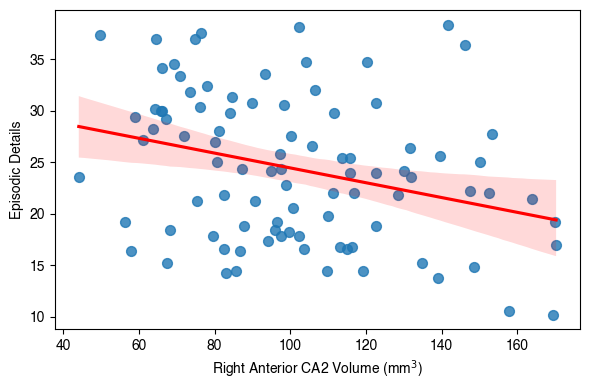

In [ ]:
# --- Set font
plt.rcParams["font.family"] = "Helvetica"

# --- Choose subfield and behavior
region_col = "CA2_Anterior"
behavior_col = "InternalTotal"

# --- Select data 
data = comp_antpost_R_synthseg[[region_col, behavior_col]].dropna()
x = data[region_col].astype(float).values
y = data[behavior_col].astype(float).values

# --- Pearson correlation + CI
r, _ = pearsonr(x, y)
rng = np.random.default_rng(42)
boot_r = [pearsonr(x[rng.integers(0, len(x), len(x))],
                   y[rng.integers(0, len(y), len(y))])[0] for _ in range(1000)]
ci_lower, ci_upper = np.percentile(boot_r, [2.5, 97.5])

# --- Print correlation
print(f"Pearson r ({region_col} ~ {behavior_col}): {r:.4f}")
print(f"95% CI (bootstrap): [{ci_lower:.4f}, {ci_upper:.4f}]")

# --- Plot
plt.figure(figsize=(6, 4))
sns.regplot(x=x, y=y,
            scatter_kws={'s': 50},
            line_kws={"color": "red"},
            ci=95)

plt.xlabel('Right Anterior CA2 Volume (mm$^3$)')
plt.ylabel('Episodic Details')
plt.tight_layout()
plt.show()